In [1]:
from pandas import read_csv, Series
from gensim.models import Word2Vec, KeyedVectors
import numpy as np
from pickle import load
from glove import Glove
import adagram
from gensim.models.wrappers import FastText, Wordrank
from embed_utils import Word2VecF, Swivel, cosine_sim, get_adagram_sense_prob, wv
from utils.string_utils import morph_parse, make_tokens

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from scipy.spatial.distance import cosine
from sklearn.decomposition import PCA

In [3]:
import matplotlib.pyplot as plt
import seaborn

In [4]:
old_err_state = np.seterr(all='raise')

def vectorize_message_2(sentence, model, num_features, vocab):
    featureVec = np.zeros((num_features), dtype='float32')
    nwords = 0
    
    tokens = make_tokens(sentence.lower(), vocab)

    for word in tokens:
        if word in vocab: 
            if model == 'word2vec':
                featureVec = np.add(featureVec, word2vec[word])
            elif model == 'wang2vec':
                featureVec = np.add(featureVec, wang2vec[word])
            elif model == 'glove':
                featureVec = np.add(featureVec, wv(glove, word))
            elif model == 'word2vecf':
                featureVec = np.add(featureVec, w2vf.word2vec(word))
            elif model == 'adagram':
                featureVec = np.add(featureVec, ada_model.sense_vector(word, get_adagram_sense_prob(ada_model, word)))
            elif model == 'fasttext':
                featureVec = np.add(featureVec, ft[word])
            elif model == 'bow':
                featureVec = np.add(featureVec, bow[word])
            elif model == 'swivel':
                featureVec = np.add(featureVec, swivel.lookup(word))
            nwords = nwords + 1
    try:
        featureVec = np.divide(featureVec, nwords)
    except FloatingPointError:
         featureVec = np.zeros((num_features), dtype='float32')
    return featureVec

In [5]:
def get_feature_vec(tokens, num_features, model, do_pca=False):
    featureVec = np.zeros(shape=(1, num_features), dtype='float32')
    nwords = 0
    for word in tokens:
        if model == 'word2vec':
            featureVec = np.add(featureVec, word2vec[word])
        elif model == 'wang2vec':
            featureVec = np.add(featureVec, wang2vec[word])
        elif model == 'glove':
            featureVec = np.add(featureVec, wv(glove, word))
        elif model == 'word2vecf':
            featureVec = np.add(featureVec, w2vf.word2vec(word))
        elif model == 'adagram':
            featureVec = np.add(featureVec, ada_model.sense_vector(word, get_adagram_sense_prob(ada_model, word)))
        elif model == 'fasttext':
            featureVec = np.add(featureVec, ft[word])
        elif model == 'bow':
            featureVec = np.add(featureVec, bow[word])
        elif model == 'swivel':
            featureVec = np.add(featureVec, swivel.lookup(word))
        nwords = nwords + 1
    if do_pca:
        pca = PCA(n_components=1)
        try:
            return pca.fit_transform((np.stack((fv1, fv2)).T)).squeeze()
        except FloatingPointError:
            return np.zeros(shape=(num_features), dtype='float32')
    else:
        try:
            return np.divide(featureVec, nwords)
        except FloatingPointError:
            return np.zeros(shape=(1,num_features), dtype='float32')

In [6]:
old_err_state = np.seterr(all='raise')

def vectorize_message(message1, message2, model, num_features, vocab):
    tokens1 = make_tokens(message1.lower(), vocab)
    tokens2 = make_tokens(message2.lower(), vocab)
    fv1 = get_feature_vec(tokens1, num_features, model)
    fv2 = get_feature_vec(tokens2, num_features, model)
    return np.hstack((fv1, fv2))

In [8]:
df = read_csv('anno2ch/annotated.csv', encoding='cp1251').dropna()
df.comment = df.comment.apply(morph_parse)
df.reference = df.reference.apply(morph_parse)

In [9]:
df_unl = read_csv('anno2ch/annotated.csv', encoding='cp1251')

In [10]:
Y = df['labels'].values

Загрузка Word2Vec-модели

In [11]:
word2vec = Word2Vec.load('models/word2vec/all_lem_100')
word2vec_vocab = word2vec.wv.vocab

Загрузка Glove-модели

In [12]:
with open('models/glove/all_lem_100', 'rb') as fp:
    glove = load(fp)
glove_vocab = glove.dictionary

Загрузка Wang2Vec-модели

In [13]:
wang2vec = KeyedVectors.load_word2vec_format('models/wang2vec/all_lem_100_cwindow', binary=True)
wang2vec_vocab = wang2vec.vocab

Загрузка Word2Vec-f-модели

In [14]:
from os import path

w2vf = Word2VecF.load(path.join('models/word2vecf', 'vecs.npy'), path.join('models/word2vecf', 'vecs.vocab'))
w2vf_vocab = w2vf._vocab

Загрузка Adagram-модели

In [15]:
ada_model = adagram.VectorModel.load('models/adagram/all_lem_100.pkl')
adagram_vocab = ada_model.dictionary.word2id.keys()

Загрузка BOW-модели

In [16]:
from pickle import load

with open('models/tfidf/all_lem', 'rb') as fp:
    bow = load(fp)

Загрузка Swivel-модели

In [17]:
swivel = Swivel('models/swivel/vocab_100.txt', 'models/swivel/vecs_100.bin')
swivel_vocab = swivel.vocab

Загрузка Fasttext-модели

In [18]:
ft = FastText.load_word2vec_format('models/fasttext/all_100_skipgram.vec')
ft_vocab = ft.vocab

Получение датасетов

In [19]:
def make_vectors_dataset(model, vocab, dim):
    vectors = np.zeros(shape=(len(df), dim*2), dtype='float32')
    for i, m in df.iterrows():
        vectors[i] = vectorize_message(m['comment'], m['reference'], model, dim, vocab)
    return vectors

In [20]:
vectors_mo = dict()

for (model, dim, vocab) in [('word2vec', word2vec_vocab, 100),
                     ('glove', glove_vocab, 100),
                     ('wang2vec', wang2vec_vocab, 100),
                     ('adagram', adagram_vocab, 100),
                     ('word2vecf', w2vf_vocab, 100),
                     ('fasttext', ft_vocab, 100),
                     ('swivel', swivel_vocab, 100),
                     ('bow', bow, 1)]:
    vectors_mo[model] = make_vectors_dataset(model, dim, vocab)

Сравнение

In [36]:
def set_plt_params():
    title_font = {'size':'80', 'color':'black', 'weight':'normal',
                  'verticalalignment':'bottom'} 
    axis_font = {'size':'80'}
    plt.figure(figsize=(20, 10))
    plt.suptitle('(b) Concatenation', fontsize=50)
    plt.grid(False)
    plt.axes(frameon = 0)
    plt.tick_params(labelsize=40)
    plt.ylim([0.76, 0.86])

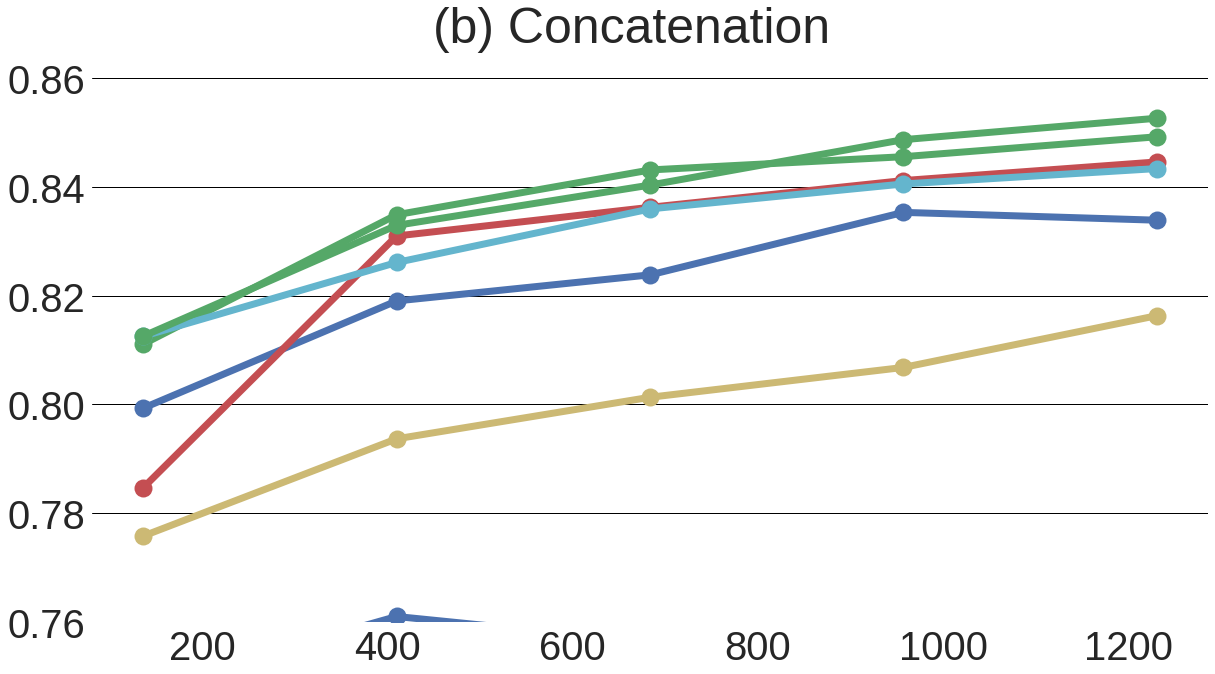

In [57]:
set_plt_params()
results = []

seaborn.set_style('white')

for name, lstyle in [('glove', 'dotted'),
                ('word2vec', 'dashed'),
                ('wang2vec', 'dashdot'),
                ('word2vecf',  (0, (20,20))),
                ('adagram', (0,(10,10))),
                ('fasttext','solid'),
                ('bow',(0,(30,30))),
                ('swivel',(0,(40,40))),
                ]:
    estimator = KNeighborsClassifier(n_neighbors = 3, algorithm='brute', metric='cosine')
    cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=0)
    train_sizes=np.linspace(0.1, 0.9, 5)
    train_sizes, train_scores, test_scores = learning_curve(estimator, vectors_mo[name], 
                                                            Y, cv=cv, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    results.append({'model' : name, 'score' : train_scores_mean})
    plt.plot(train_sizes, train_scores_mean, marker='o', markersize=18, label=name, linewidth=7)

plt.grid(True, axis='y', linewidth=1, color='black')
plt.savefig('classifiers_concat.png', bbox_inches='tight')
plt.show()

In [53]:
results

[{'model': 'glove',
  'score': array([ 0.79926471,  0.81902439,  0.82383041,  0.8353187 ,  0.8338749 ])},
 {'model': 'word2vec',
  'score': array([ 0.81102941,  0.83487805,  0.84312865,  0.84555904,  0.84922827])},
 {'model': 'wang2vec',
  'score': array([ 0.78455882,  0.83097561,  0.83625731,  0.84117032,  0.84459789])},
 {'model': 'word2vecf',
  'score': array([ 0.74779412,  0.73780488,  0.73567251,  0.73615465,  0.73428107])},
 {'model': 'adagram',
  'score': array([ 0.77573529,  0.79365854,  0.80131579,  0.80679206,  0.81632819])},
 {'model': 'fasttext',
  'score': array([ 0.8125    ,  0.82609756,  0.83596491,  0.84054336,  0.84337937])},
 {'model': 'bow',
  'score': array([ 0.74779412,  0.76097561,  0.75628655,  0.74702194,  0.72778229])},
 {'model': 'swivel',
  'score': array([ 0.8125    ,  0.83292683,  0.84035088,  0.84869383,  0.85264013])}]